In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

1.提取并清洗数据

In [2]:
base_path='data/电商用户数据.xlsx'
def read_data(file_name):
    df=pd.read_excel(file_name)
    df_cleaned = df.drop_duplicates(subset=['买家昵称', '付款日期', '订单状态'], keep='first')
    df_cleaned = df.dropna(subset=['城市'])
    return df_cleaned

In [3]:
df_cleaned=read_data(base_path)

2.EDA探索性数据分析

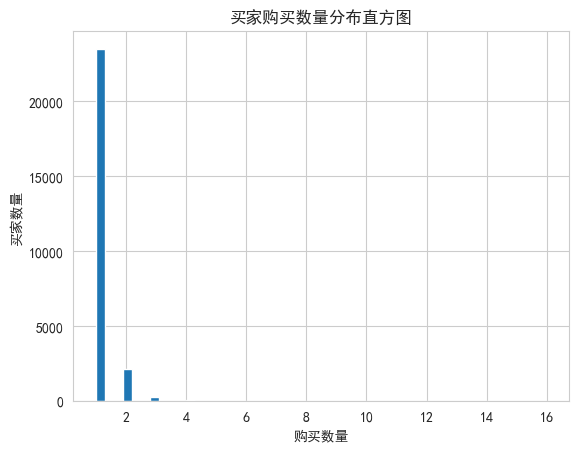

In [4]:
df_cleaned.groupby('买家昵称')['购买数量'].count ().plot(kind='hist',bins=50)
plt.xlabel('购买数量')
plt.ylabel('买家数量')
plt.title('买家购买数量分布直方图')
plt.show()

用户倾向于单件即时消费特征,几乎无凑单行为

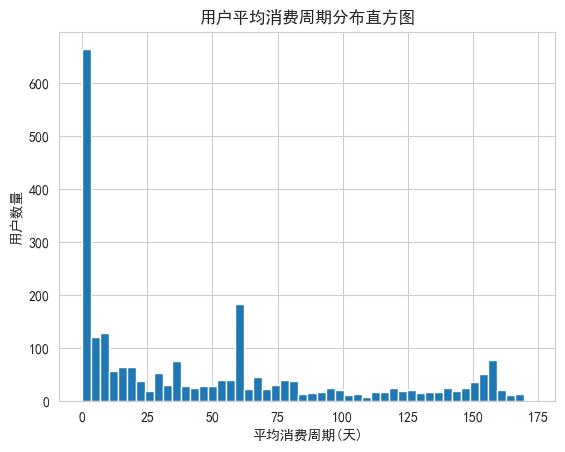

平均消费周期的平均值: 49.00 天
平均消费周期的中位数: 33.00 天


In [5]:
# 计算每个用户的平均消费周期
def calculate_avg_purchase_cycle(df):
    df_sorted = df.sort_values(['买家昵称', '付款日期'])
    # 计算每个用户相邻购买之间的时间间隔
    df_sorted['时间间隔'] = df_sorted.groupby('买家昵称')['付款日期'].diff()
    # 计算每个用户的平均消费周期
    avg_cycle = df_sorted.groupby('买家昵称')['时间间隔'].mean()
    return avg_cycle
user_avg_cycle = calculate_avg_purchase_cycle(df_cleaned)
user_avg_cycle.dt.days.plot(kind='hist', bins=50)
plt.xlabel('平均消费周期(天)')
plt.ylabel('用户数量')
plt.title('用户平均消费周期分布直方图')
plt.show()
print(f"平均消费周期的平均值: {user_avg_cycle.mean().days:.2f} 天")
print(f"平均消费周期的中位数: {user_avg_cycle.median().days:.2f} 天")


大多数用户的平均消费周期集中在 0~25天 的区间内，其中在 0天 左右的用户数量最多（超过600人），表明有大量用户具有非常短的消费周期，可能为频繁购买或复购用户。

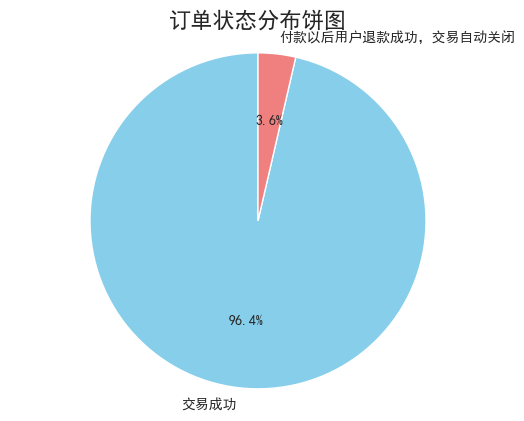

In [6]:
df_cleaned.groupby('订单状态')['买家昵称'].count().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightcoral']
)
plt.title('订单状态分布饼图', fontsize=16)
plt.ylabel('')
plt.axis('equal')
plt.show()

订单交易状态良好

In [7]:
df_cleaned['实付金额'].mean ()

np.float64(126.26668285238624)

In [8]:
bins=[0,25,50,100,200,300,500]

(array([   0., 4757., 8744., 9906., 5392.,   28.]),
 array([  0.,  25.,  50., 100., 200., 300., 500.]),
 <BarContainer object of 6 artists>)

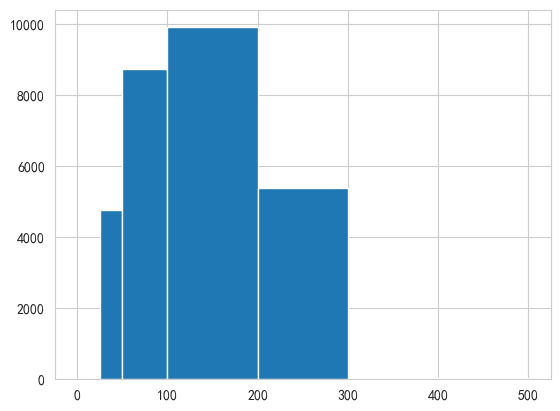

In [9]:
plt.hist(df_cleaned['实付金额'],bins=bins)

小额消费为主,平均消费为120,应选择薄利多销的策略

<Axes: xlabel='城市'>

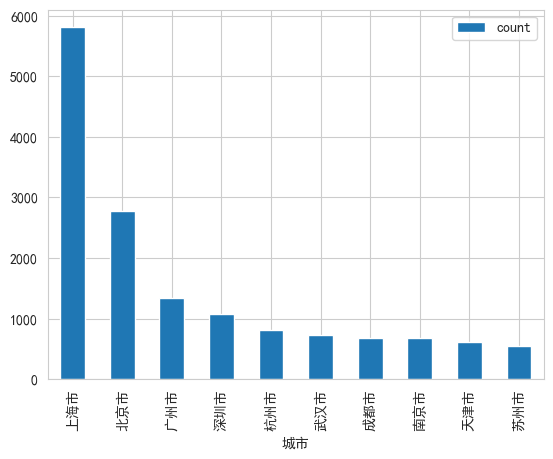

In [10]:
df_cleaned['城市'].value_counts().reset_index().iloc[:10].plot(x='城市',y='count',kind='bar')

消费地区主力多为沿海地区,符合中国经济分布

3.构造用户画像

In [35]:
data=df_cleaned[['买家昵称','付款日期','实付金额','购买数量']]
lastest=(data.sort_values(['买家昵称','付款日期'], ascending=[True, False]).drop_duplicates(subset=['买家昵称'],keep='first').reset_index(drop=True))
now=pd.to_datetime('2019-7-1')
lastest['difftime']=(now-lastest['付款日期']).dt.days
lastest=lastest[['买家昵称','difftime']]
data=pd.merge(data,lastest,on='买家昵称',how='left')
data.rename(columns={'difftime':'R'},inplace=True)
data_f = data.groupby('买家昵称')['购买数量'].count().reset_index()
data_f.rename(columns={'购买数量': 'F'}, inplace=True)
data_m = data.groupby('买家昵称')['实付金额'].sum().reset_index()
data_m.rename(columns={'实付金额': 'M'}, inplace=True)
data = pd.merge(data, data_f, on='买家昵称', how='left')
data = pd.merge(data, data_m, on='买家昵称', how='left')



In [38]:
# 注意：我们对列使用 .rank(method='first') 来处理重复值，这是更稳妥的做法
rfm['R_score'] = pd.qcut(rfm['R'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['F'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['M'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

In [39]:
rfm

,买家昵称,R,F,M,R_score,F_score,M_score
0,叫我李2,180,1,186,1,1,4
1,0cyb1992,180,1,145,1,1,3
2,萝污萌莉,180,1,194,1,1,4
3,atblovemyy,180,1,84,1,1,2
4,小星期鱼,170,2,146,1,5,3
...,...,...,...,...,...,...,...
25943,2松松贝贝0,0,1,69,5,5,2
25944,2ganlin7,0,1,216,5,5,5
25945,点大a,0,1,231,5,5,5
25946,8陈爷558989,0,1,99,5,5,3


In [33]:
data_m

,买家昵称,M
0,.blue_ram,49
1,.christiny,183
2,.willn1,34
3,.托托m,37
4,0000妮,164
...,...,...
25943,龙火师,175
25944,龙魔鬼女,87
25945,龟mil宝,497
25946,！谢鹏逗逼？,137


In [34]:
data = pd.merge(data, data_f, on='买家昵称', how='left')
data = pd.merge(data, data_m, on='买家昵称', how='left')

买家昵称
.blue_ram     1
.christiny    1
.willn1       1
.托托m          1
0000妮         1
             ..
龙火师           1
龙魔鬼女          1
龟mil宝         2
！谢鹏逗逼？        1
～小邱～          1
Name: 购买数量, Length: 25948, dtype: int64

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
28827   NaN
28828   NaN
28829   NaN
28830   NaN
28831   NaN
Name: M, Length: 28832, dtype: float64

Index(['买家昵称', '付款日期', '订单状态', '实付金额', '邮费', '省份', '城市', '购买数量'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28832 entries, 0 to 28831
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   买家昵称    28832 non-null  object        
 1   付款日期    28832 non-null  datetime64[ns]
 2   实付金额    28832 non-null  int64         
 3   购买数量    28832 non-null  int64         
 4   R       28832 non-null  int64         
 5   F       0 non-null      float64       
 6   M       0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 1.5+ MB
